## Sinais e Sistemas Dinâmicos - Projeto final
### Samuel Pordeus - 11400947
### Elcius Ferreira - 11400968

Importando os módulos necessários

In [1]:
import scipy.io.wavfile
import pydub
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
from pydub import AudioSegment
from pydub.playback import play

%matplotlib inline

Abaixo importamos a música que vai ser processada pelo programa utilizando o módulo SciPy:


In [2]:
rate,audData=scipy.io.wavfile.read("wav/nirvana.wav")

Checando o tamanho da música em segundos:

In [3]:
length = audData.shape[0] / rate
length

225.69795918367348

Aqui temos de separar a música em dois canais, pois ela é Stereo. Optamos por não transformar em Mono pois ao tentar fazer isso manualmente utilizando a SciPy acontece um grande dano ao arquivo de som.

In [4]:
channel1=audData[:,0] #left
channel2=audData[:,1] #right

Checando algumas propriedades do arquivo de som:

In [5]:
audData.dtype

dtype('int16')

In [6]:
#Energy
np.sum(channel1.astype(float)**2)

50712767452163.0

### Amplitude de som vs Tempo

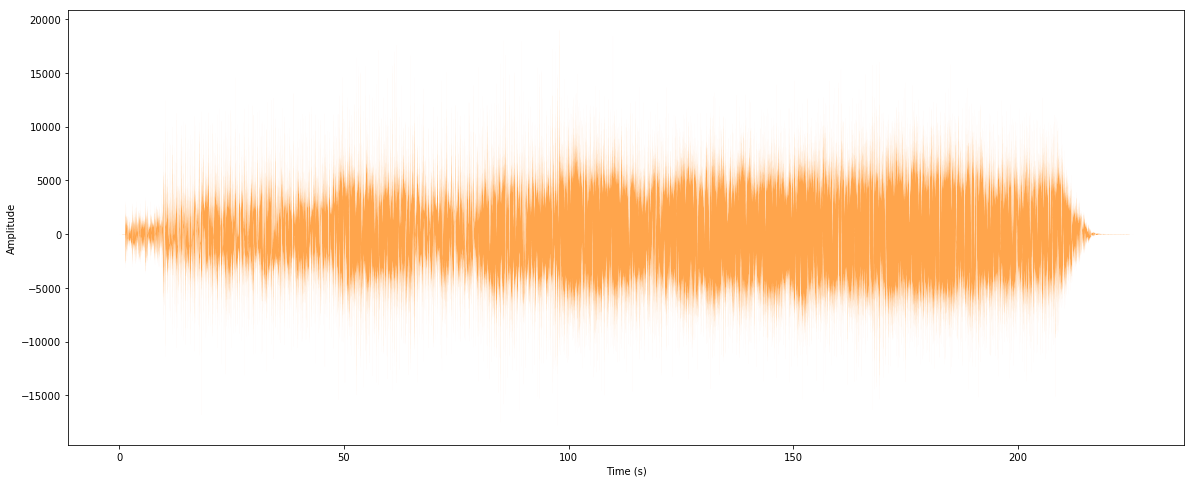

In [7]:
#create a time variable in seconds
time = np.arange(0, float(audData.shape[0]), 1) / rate

#plot amplitude (or loudness) over time
plt.figure(1, figsize=(20,8))
plt.plot(time, channel1, linewidth=0.01, alpha=0.7, color='#ff7f00')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Utilizando a fast fourier transform no arquivo de som

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


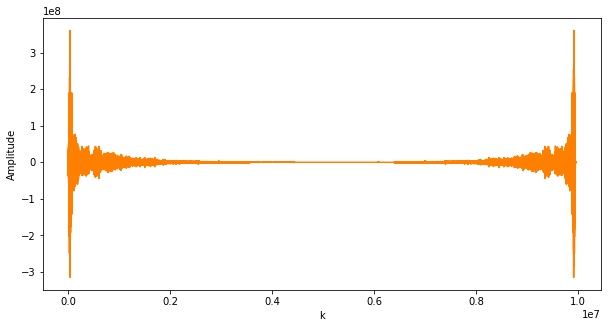

In [8]:
from numpy import fft as fft

fourier=fft.fft(channel1)

plt.figure(1, figsize=(10,5))
plt.plot(fourier, color='#ff7f00')
plt.xlabel('k')
plt.ylabel('Amplitude')

# Plotando dB vs kHz

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


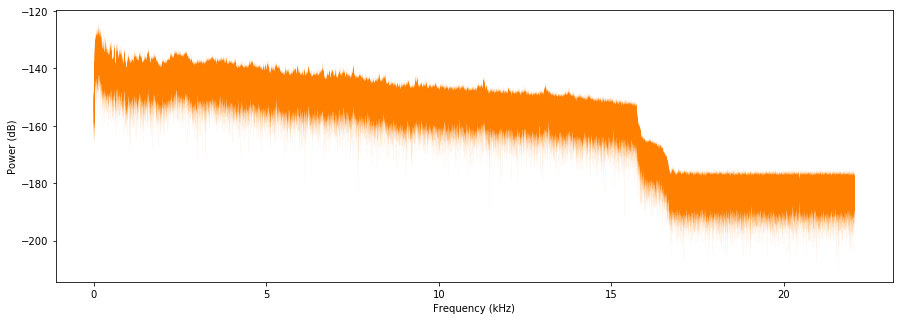

In [43]:
n = len(channel1)
fourier = fourier[0:int(n/2)]

# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)

#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);

plt.figure(1, figsize=(15,5))
plt.plot(freqArray/1000, 10*np.log10(fourier), color='#ff7f00', linewidth=0.02)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')

# Spectograma

/home/samuelspordeus/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7222: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


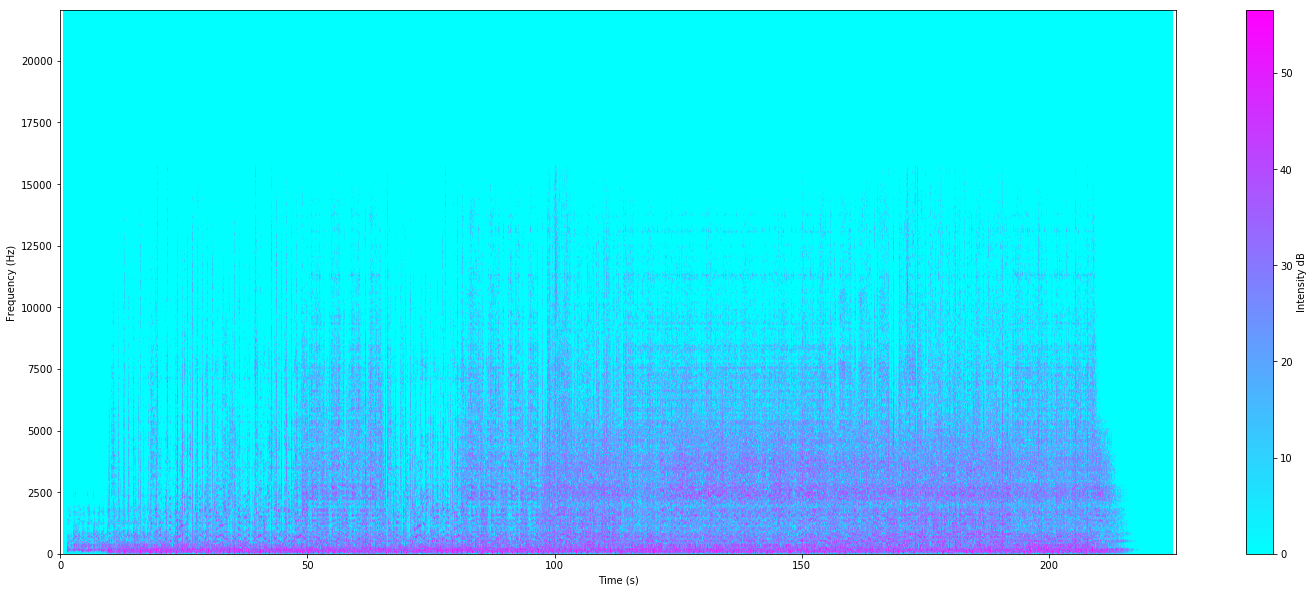

In [51]:
plt.figure(1, figsize=(25,10))
Pxx, freqs, bins, im = plt.specgram(channel1, Fs=rate, vmin=0, NFFT=1024, cmap=plt.get_cmap('cool'), window=mlab.window_hanning)
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar.set_label('Intensity dB')
plt.savefig("/home/samuelspordeus/fft.pdf", dpi = 200)

In [48]:
np.where(freqs==10034.47265625)
MHZ10=Pxx[233,:]
plt.xlabel('Time')
plt.ylabel('Power')
plt.plot(bins, MHZ10, color='#ff7f00')

44100

# A segmentação da voz
Informações que temos ao nosso favor:
* Sabemos, lendo estudos realizados em cima das músicas de Nirvana, que a voz de Kurt Cobain tem um range de 61hz-1046hz, pois ele vai de B1 a C6 em notas musicais.
* Dificilmente a voz de um cantor masculino passa de 1000hz, mas, pelo que analisamos no spectrograma da nossa *Sample*, boa parte do tempo a voz do cantor fica numa faixa mais central, entre 500-700.

Para separarmos a voz dos instrumentos, adotamos duas etapas:

1. Presumindo que a voz estava nos centros dos canais Stereo, utilizamos deste fato para suprimirmos a voz do cantor.
2. Utilizamos um filtro passa-baixo, utilizando como frequencia de corte um valor que achamos o ideal após analisarmos cuidadosamente o spectograma e conseguirmos discernir em que faixa estava a voz de **Kurt**

## Primeira etapa: Remover os centros do arquivo Stereo
Após analisarmos cuidadosamente os dois canais do arquivo estéreo utilizando uma versão de alta resolução do nosso spectrograma, vimos que era possível utilizar essa técnica para dar uma suprimida na voz do cantor.

Utilizamos a biblioteca PyDub, que contém diversas funções para tratamento de áudio.

In [56]:
musica = AudioSegment.from_file("wav/nirvana.wav", format="wav")

musica_L = sound_stereo.split_to_mono()[0]
musica_R = sound_stereo.split_to_mono()[1]

musica_R_inv = musica_R.invert_phase()
musica_centersOut = musica_L.overlay(musica_R_inv)

fh = musica_centersOut.export("centersout.wav", format="wav")

# Segunda etapa: Filtro passa-baixo

Pegamos o arquivo com os centros removidos e aplicamos um filtro passa-baixo com uma frequencia de corte de **400hz**

In [54]:
import wave, sys, math, contextlib

fname = 'centersout.wav'
outname = 'filtered.wav'

cutOffFrequency = 400.0

def running_mean(x, windowSize):
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.fromstring(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

with contextlib.closing(wave.open(fname,'rb')) as spf:
    sampleRate = spf.getframerate()
    ampWidth = spf.getsampwidth()
    nChannels = spf.getnchannels()
    nFrames = spf.getnframes()

    # Extract Raw Audio from multi-channel Wav File
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

    # get window size
    # from http://dsp.stackexchange.com/questions/9966/what-is-the-cut-off-frequency-of-a-moving-average-filter
    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    # Use moviung average (only on first channel)
    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open(outname, "w")
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

### O arquivo de output foi salvo na mesma pasta que esse ipynb se encontra com o nome: *filtered.wav*

# Considerações finais
Infelizmente não conseguimos segmentar a voz em um arquivo de áudio diferente, devido a forma em que os arquivos de áudio são tratados pelas bibliotecas que utilizamos no processo e devido também ao alto grau de complexidade da tarefa. Contudo, tivemos uma grande 'ajuda' do Spectrograma na ajustagem do parâmetro da frequencia de corte.

Dito isso tudo, aprendemos bastante sobre filtros, pois tivemos que estudar muitos conceitos aprendidos em sala, que nos pareciam distantes da realidade, novamente. Vê-los sendo aplicados na prática edificou o nosso conhecimento no assunto.